In [1]:
import numpy as np
import cv2
import os
import PIL
import matplotlib.pyplot as plt
import sys
import torch
from tqdm import tqdm
import torch.nn as nn
sys.path.append("./Utils")
from utils import get_loaders, save_checkpoint, load_checkpoint, train_fn, save_predictions_as_imgs
sys.path.append('./Models')
from U_net import UNET
import torchvision

In [2]:
path_train = "../Data/dataset DRIVE/training/images/"
training_images = os.listdir(path_train)

In [3]:
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

Text(0.5, 1.0, '21')

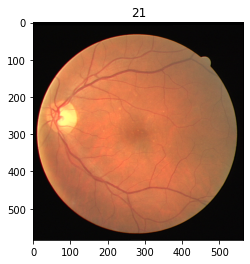

In [4]:
plt.imshow(train_images['21'])
plt.title('21')

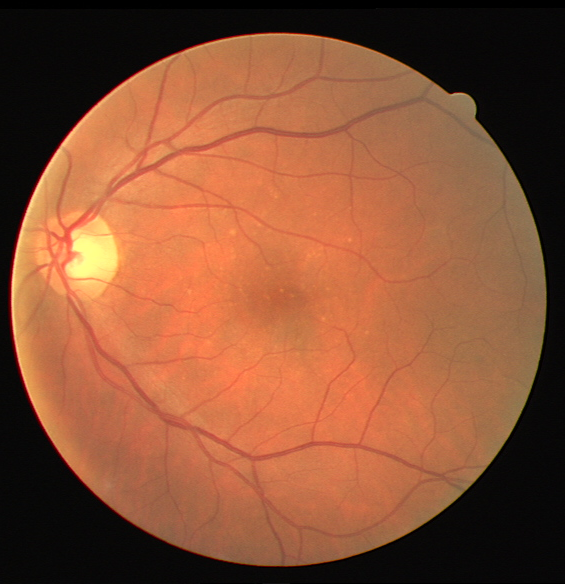

In [5]:
PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB')

In [6]:
import torchvision.transforms.functional as TF

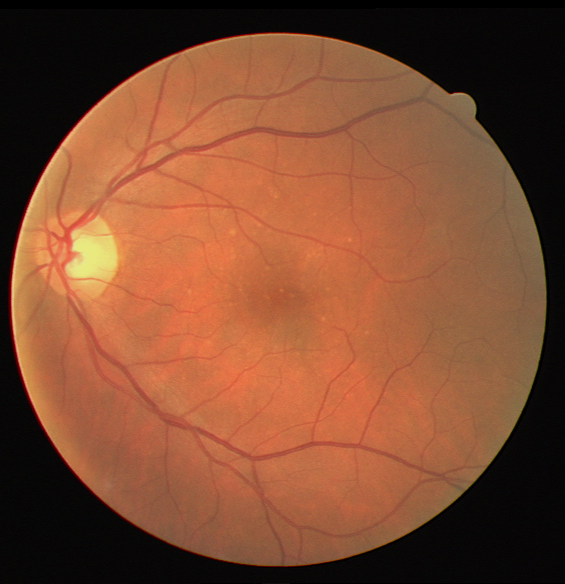

In [7]:
TF.adjust_brightness(PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB'), np.random.uniform(0.5, 1.5))

In [8]:
#Procesado de los labels

In [8]:
path_labels = "../Data/dataset DRIVE/training/1st_manual/"
training_labels = os.listdir(path_labels)
labels = {}
for image in training_labels:
    img = np.array(PIL.Image.open(f'{path_labels}{image}').convert("L"), dtype=np.float32)
    labels[image[0:2]] = img

Text(0.5, 1.0, '21')

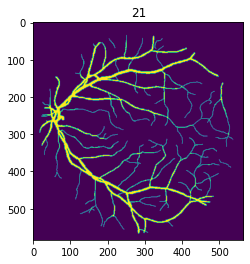

In [9]:
plt.imshow(labels['21'])
plt.title('21')

Text(0.5, 1.0, '21')

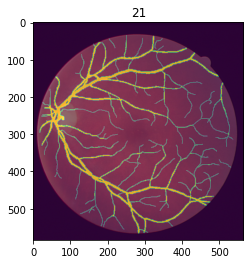

In [10]:
plt.imshow(labels['21'], alpha=1)
plt.imshow(train_images['21'], alpha=0.4)
plt.title('21')

In [11]:
# Model Hyperparams
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
NUM_EPOCHS = 1500
NUM_WORKERS = 1
PIN_MEMORY = True
LOAD_MODEL = True
LOSS_WEIGHTS = 5
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss(pos_weight= torch.tensor(LOSS_WEIGHTS)) # Crossentropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training Loader params

TRAIN_IMG_DIR = "/Users/alberto/Desktop/TFM/Data/dataset DRIVE/training/images"
TRAIN_MASK_DIR = "/Users/alberto/Desktop/TFM/Data/dataset DRIVE/training/1st_manual"
VAL_IMG_DIR = "/Users/alberto/Desktop/TFM/Data/dataset DRIVE/validation/images"
VAL_MASK_DIR = "/Users/alberto/Desktop/TFM/Data/dataset DRIVE/validation/1st_manual"
RESIZE = None
ROTATION = [-90, 90]
HFLIP_PROB = 0.5
BRIGHTNESS = [0.5, 1.5]
CONTRAST = [0.5, 1.5]
GAMMA = [0.5, 1.5]

In [12]:
   train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        RESIZE,
        ROTATION,
        HFLIP_PROB,
        BRIGHTNESS,
        CONTRAST,
        GAMMA,
        NUM_WORKERS,
        PIN_MEMORY)

Feature batch shape: torch.Size([4, 3, 584, 565])
Labels batch shape: torch.Size([4, 584, 565])
The Train image numbers present in the batch are: ('29', '28', '22', '30')


Text(0.5, 1.0, '29')

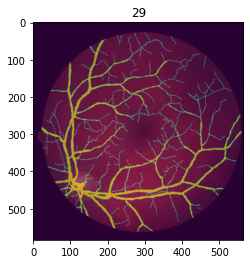

In [13]:
train_features, train_labels, numbers = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"The Train image numbers present in the batch are: {numbers}")
img = train_features[0].squeeze()
label = train_labels[0]
number = numbers[0]
plt.imshow(label, alpha=1)
plt.imshow(img.permute(1, 2, 0) , alpha=0.4)
plt.title(number)

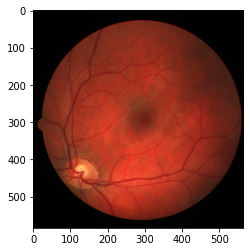

In [14]:
plt.imshow(img.permute(1, 2, 0) , alpha=1)

In [15]:
# Test
#x = torch.randn((4, 3, 160, 160))
#model = UNET(in_channels=3, out_channels=1)
#preds = model(x)
#assert preds.shape[2:] == x.shape[2:]
#
#x = torch.randn((train_features.shape))
#x = x.view(x.shape[0], 3, x.shape[2], -1)
#preds = model(x)
#assert preds.shape[2:] == x.shape[2:]

#print(train_features.shape)
# Habrá que cambiar la forma de las imágenes de entrada a
# [batch, channels, H, V] actualmente está en [batch, H, V, channels]

# Training

In [16]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss() # Crossentropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [19]:
if LOAD_MODEL:
    load_checkpoint(torch.load("Checkpoints/my_check.pth.tar", map_location=torch.device(DEVICE)),
    model)
else:
    accuracy = []
    dice = []
    saved = []
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
        
        # Check accuracy
        accuracy_score, dice_score = check_accuracy(val_loader, model, device=DEVICE)
        accuracy.append(accuracy_score)
        dice.append(dice_score.item())
    
        if accuracy_score >= np.max(accuracy):
            # Save model
            checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()}
            save_checkpoint(checkpoint, "./drive/MyDrive/TFM/Code/Checkpoints/my_check.pth.tar")
            saved.append(True)
        else:
            saved.append(False)

 => Loading checkpoint 


In [20]:
save_predictions_as_imgs(val_loader, model, folder="./Checkpoints/images_predictions/", device=DEVICE)

In [25]:
acc = np.load("Checkpoints/accuracy.npy")
dice = np.load("Checkpoints/dice.npy")
saved = np.load("Checkpoints/saved.npy")

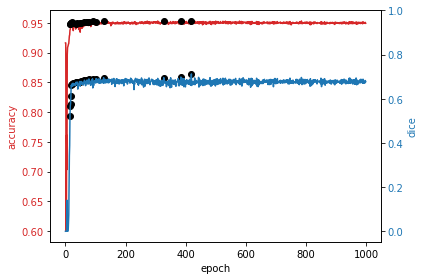

In [32]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy', color=color)
ax1.plot(range(len(acc)), acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('dice', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(acc)), dice, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.scatter(np.where(saved), acc[saved], color="k")
plt.scatter(np.where(saved), dice[saved], color="k")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()